# <center> Project IMA201 - Skin Lesion Segmentation Using Color Channel Optimization and Clustering-based Histogram Thresholding

# <div style="text-align: right">Done  by : Yasmine Masmoudi - Chaima Elmessai </div>

## Project Steps :  
1. Color space transformation 
2. Pre-processing :
*  Hair removal.
*  Black border Removal.
* Noise filtering: Pillbox filter.
* Intensity adjustment.
3. Histogram thresholding: Otsu method.
4. Post-processing.
* CCA.
* Filling of holes.
5. Final results 
6. Process Limits. 
7. Evaluation of the method.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Skin_Lesion/output_folder/

/content/drive/MyDrive/Skin_Lesion/output_folder


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import closing,erosion
import cv2,os
from pillbox import Circular_Filter
from channel_transform import color_channel
from main import segment 
import border
from New_method_Border_Detection import New_method
from metrics import *
from hair_removal import *
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## I. Input Data + Ground Truth Data

In [24]:
path=os.getcwd()
train = sorted(os.listdir(path+'/melanoma/skinlesion_image'))
ground_truth = sorted(os.listdir(path+'/melanoma/ground_truth'))
train.append(train.pop(1))
ground_truth.append(ground_truth.pop(1))
lesion_path = path+'/melanoma/skinlesion_image/'

# I. Hair Removal

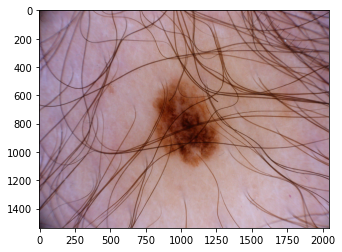

In [17]:
path = os.getcwd()
sample = plt.imread(path +'/hair_images/lesion.jpg')
plt.imshow(sample)

In [18]:
# Structure elements
S0 = np.ones((1,13),dtype='uint8') # Horizontal
S0[0,0],S0[0,-1]=0,0
S45 = np.eye((9),dtype='uint8')   # Diagonal
S45[0,0],S45[-1,-1]= 0,0
S90 = np.ones((13,1),dtype='uint8') # Vertical
S90[0,0],S90[12,0]=0,0
image = sample.copy()

Or,Og,Ob = image[:,:,0],image[:,:,1],image[:,:,2]
# Generalized grayscale closing image of the original red band
OrS0,OrS45,OrS90 =  closing(Or,S0),closing(Or,S45),closing(Or,S90)
Gr = np.abs(Or-np.maximum(OrS0,OrS45,OrS90))

# Generalized grayscale closing image of the original Green band
OgS0,OgS45,OgS90 =  closing(Og,S0),closing(Og,S45),closing(Og,S90)
Gg = np.abs(Og-np.maximum(OgS0,OgS45,OgS90))

# Generalized grayscale closing image of the original blue band
ObS0,ObS45,ObS90 =  closing(Ob,S0),closing(Ob,S45),closing(Ob,S90)
Gb = np.abs(Ob-np.maximum(ObS0,ObS45,ObS90))

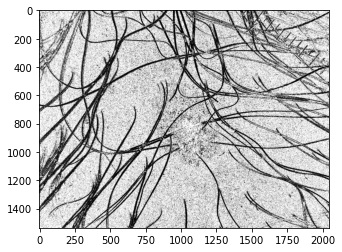

In [19]:
# Threshold Choice 
T = 250
# Generating Mask per color channel
Mr, Mg, Mb = mask(Gr,T),mask(Gg,T),mask(Gb,T) 
#Geenrating the hair mask = Union of three Mj masks
M  = hair_mask(Mr,Mg,Mb)
plt.imshow(M, cmap='gray')

In [ ]:
#@title
#plt.imsave('first_mask_2.png',M,cmap='gray')

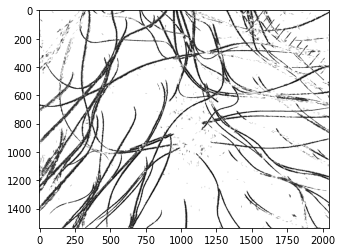

In [20]:
## Localisation of Hair pixels
Mask = locate(M,9,7)
#15 , 8
#10 , 5
plt.imshow(Mask, cmap='gray')

In [ ]:
#@title
#plt.imsave('binary_mask_2.png',Mask,cmap='gray')

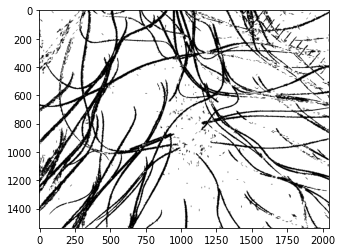

In [ ]:
# Working on eroded Mask To highlight the presence of hairs in the image.
eroded = erosion(Mask)
plt.imshow(eroded, cmap='gray')

### Comparison of Hair Removal results using the obtained Mask and Mask after Erosion.

In [ ]:
Mask  = eroded.copy()
inter = interpolate(Mask,image_intert,5)

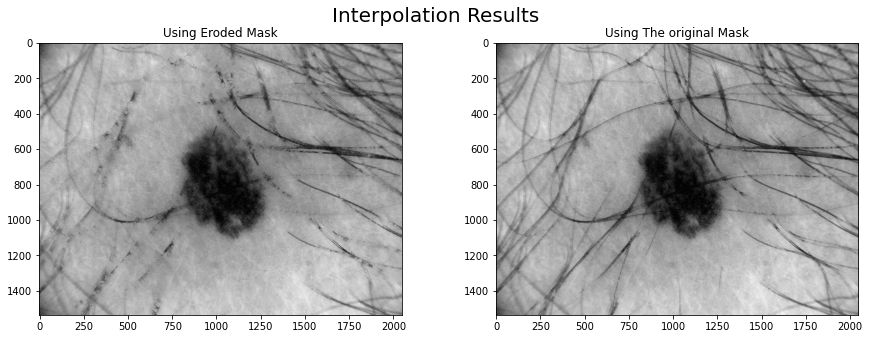

In [ ]:
#@title
fig, ax = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Interpolation Results',fontsize=20)
ax[0].imshow(inter,cmap='gray')
ax[0].set_title('Using Eroded Mask');
ax[1].imshow(inter_mask,cmap='gray')
ax[1].set_title('Using The original Mask');

### Generating the hair removal results of coloured image

In [ ]:
#@title
image_channelR = sample[:,:,0].copy()
image_channelG = sample[:,:,1].copy()
image_channelB = sample[:,:,2].copy()
interB = interpolate(eroded,image_channelB,5)
interR = interpolate(eroded,image_channelR,5)
interG = interpolate(eroded,image_channelG,5)

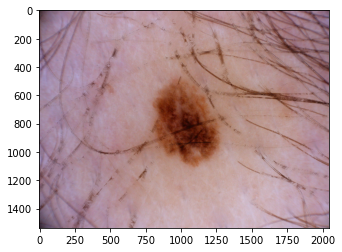

In [ ]:
interpolated= cv2.merge((interR,interG,interB))
plt.imshow(interpolated)

In [ ]:
#@title
#plt.imsave('interpolated.png',interpolated)

In [ ]:
#@title
segmentation_hairedR= segment(interpolated[:,:,0])
segmentation_hairedG= segment(interpolated[:,:,1])
segmentation_hairedB= segment(interpolated[:,:,2])
adjuR,adjuG,adjuB=segmentation_hairedR[1],segmentation_hairedG[1],segmentation_hairedB[1]


### The segmentation results of this image

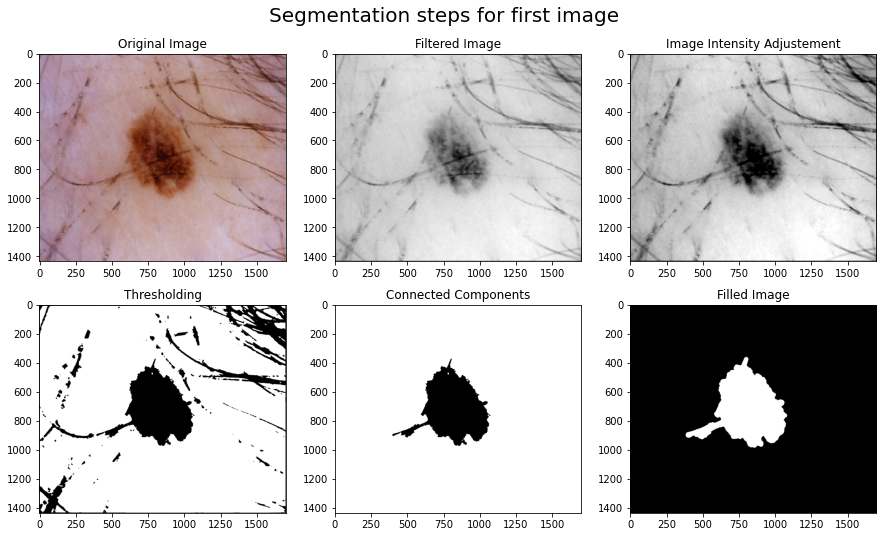

In [ ]:
#@title
# Cropping the image to remove the rest of balck hair in borders.
segmentation_hairedR= segment(interpolated[100:,200:1900,0])

steps = [interpolated[100:,200:1900]]+segmentation_hairedR
fig, axs = plt.subplots(2, 3,figsize=(15,8))
steps_names = ['Original Image','Filtered Image','Image Intensity Adjustement','Thresholding','Connected Components','Filled Image']
fig.suptitle(f'Segmentation steps for first image',fontsize=20)
k=0
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9 , top=0.9  , wspace=0.2, hspace=0.2)
for i in range(2):
  for j in range(3):
    axs[i][j].imshow(steps[k],cmap='gray');
    axs[i][j].set_title(f'{steps_names[k]}')
    axs[i][j].grid(False)
    k+=1
  
plt.show()

### Hair Removal :
* Otsu's method detected several undesirable details, it considered the hairs and the lesion as a single object. In this way, some false deatails appear and have been plugged by the morphological operator. Thus, this image with alot of black hair pixels limits the segmentation performance that's why it won't be considered in further steps of color transformation and segmentation. 

In [ ]:
#@title
#plt.imsave('interpolation.png',inter,cmap='gray')

### Limits of Hair Removal Method 



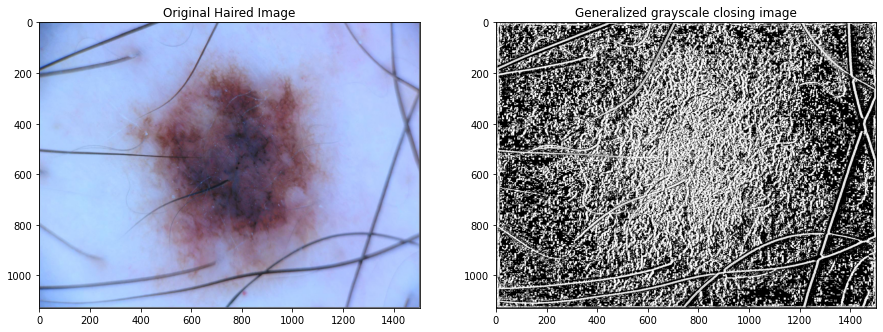

In [ ]:
#@title
sample_less_hair = plt.imread(path +'/ISIC_0000042.jpg')
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax[0].imshow(sample_less_hair)
ax[0].set_title('Original Haired Image');
ax[1].imshow(Gg,cmap='gray')
ax[1].set_title('Generalized grayscale closing image');

* The limits of this method appear clearly  with another image where the results are discouraging just from plotting the generalized gray scale closing image .

# II . Black Border Removal

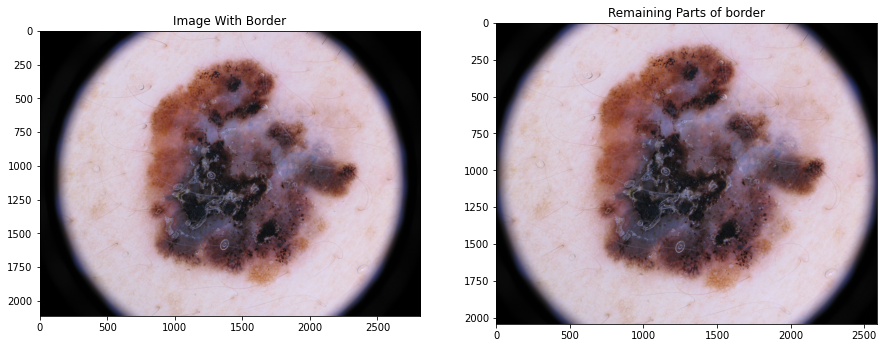

In [ ]:
#@title
lesion_with_border = plt.imread(lesion_path+train[3])
l1,l2= border.test(lesion_with_border,0)
c1,c2 = border.test(lesion_with_border,1)
removed_border = lesion_with_border[l1:l2,c1:c2]
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax[0].imshow(lesion_with_border)
ax[0].set_title('Image With Border');
ax[1].imshow(removed_border)
ax[1].set_title('Remaining Parts of border');

* In the case of this circular image, the mothod doesn't give a satisfying result because there is a remaining part of the black frame : It is the black corners.


### Amelioration for border removal Method 

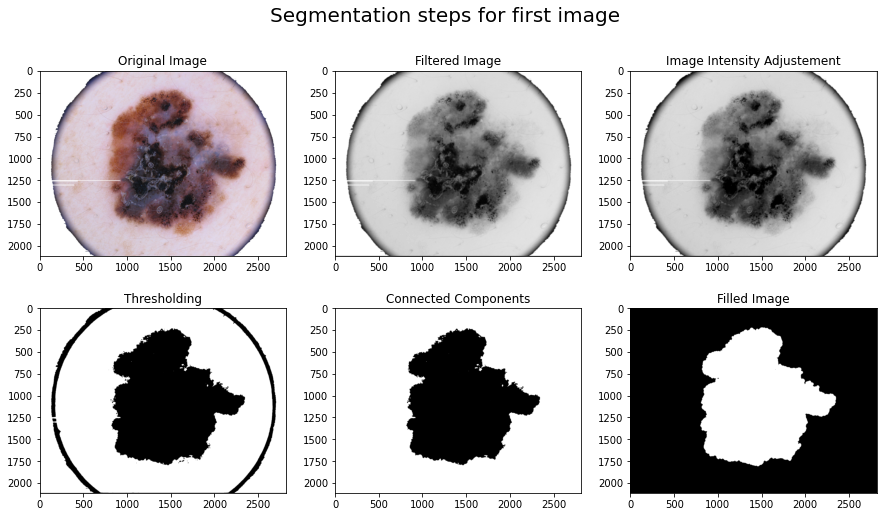

In [ ]:
#@title
img = lesion_with_border.copy()
iresult = New_method(img)
steps = [iresult]+segment(iresult[:,:,0])
fig, axs = plt.subplots(2, 3,figsize=(15,8))
steps_names = ['Original Image','Filtered Image','Image Intensity Adjustement','Thresholding','Connected Components','Filled Image']
fig.suptitle(f'Segmentation steps for first image',fontsize=20)
k=0
for i in range(2):
  for j in range(3):
    axs[i][j].imshow(steps[k],cmap='gray');
    axs[i][j].set_title(f'{steps_names[k]}')
    axs[i][j].grid(False)
    k+=1
plt.show()

* After applying  another method, based on edge detection using the canny filter, on this circular image, we notice that the black pixels,except those which belong to the edge, are removed. So we have a better result with this method

# III. Segmentation steps : Preprocessing + Thresholding + Postprocessing



In [25]:
lesion_path = path+'/melanoma/skinlesion_image/'
lesions = plt.imread(lesion_path+train[8]),plt.imread(lesion_path+train[9]),plt.imread(path+'/melanoma/image_rgb_article.png')
steps_names = ['Original Image','Filtered Image','Image Intensity Adjustement','Thresholding','Connected Components','Filled Image']

### Before discussing the limits of the method this following plot illustrates the result of connected component analysis CCA where all undesirable details are eliminated

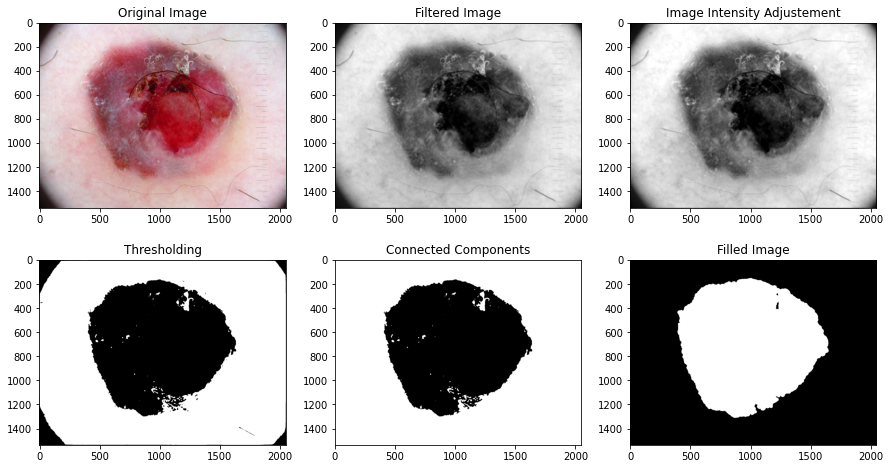

In [26]:
#@title
image8 = plt.imread(lesion_path+train[7])
sggg = segment(image8[:,:,1])
steps = [image8]+sggg
k=0
fig, axs = plt.subplots(2, 3,figsize=(15,8))
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9 , top=0.9  , wspace=0.2, hspace=0.2)
for i in range(2): 
  for j in range(3):
    axs[i][j].imshow(steps[k],cmap='gray');
    axs[i][j].set_title(f'{steps_names[k]}')
    axs[i][j].grid(False)
    k+=1
plt.show()

### Chosen examples of segmentation process results : 
* We will work on "Green" Channel of the 3 selected images and show the several outputs of segmentation steps. The choice of color channel comes after several temptations and selected as best channel in RGB space. 
* We illustrate this point further after evaluation of the process performances.

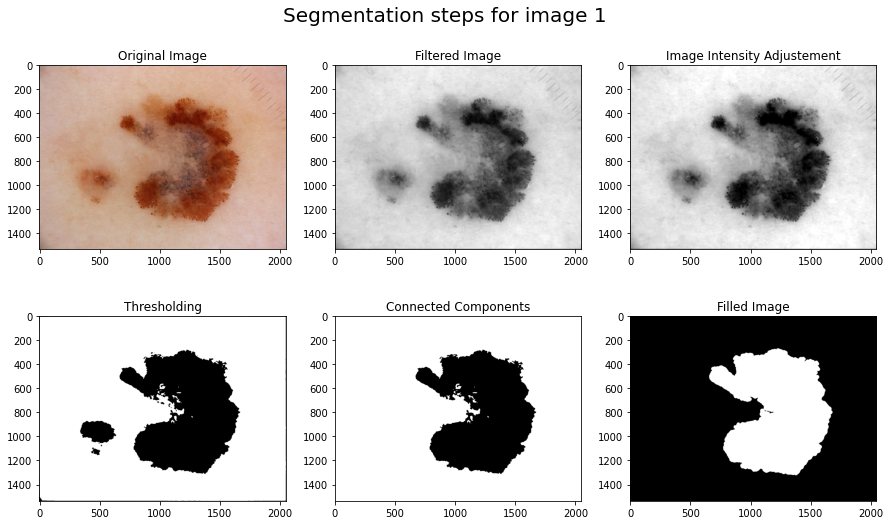

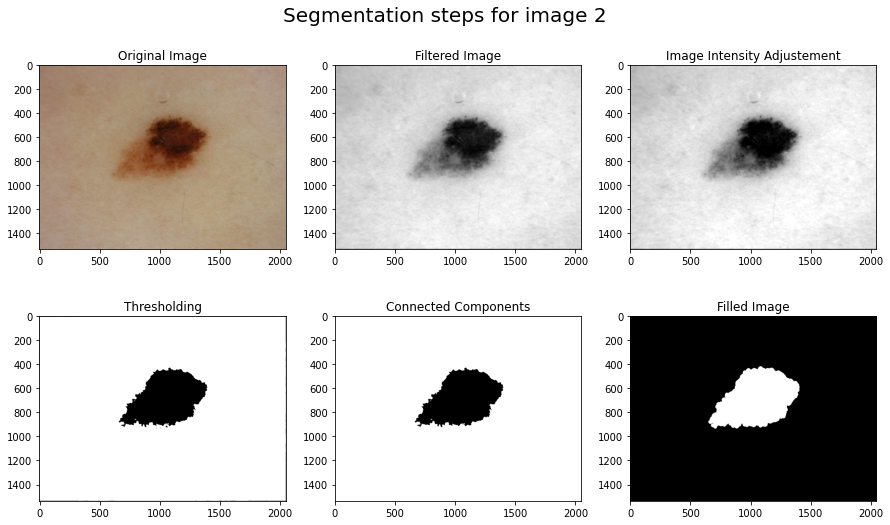

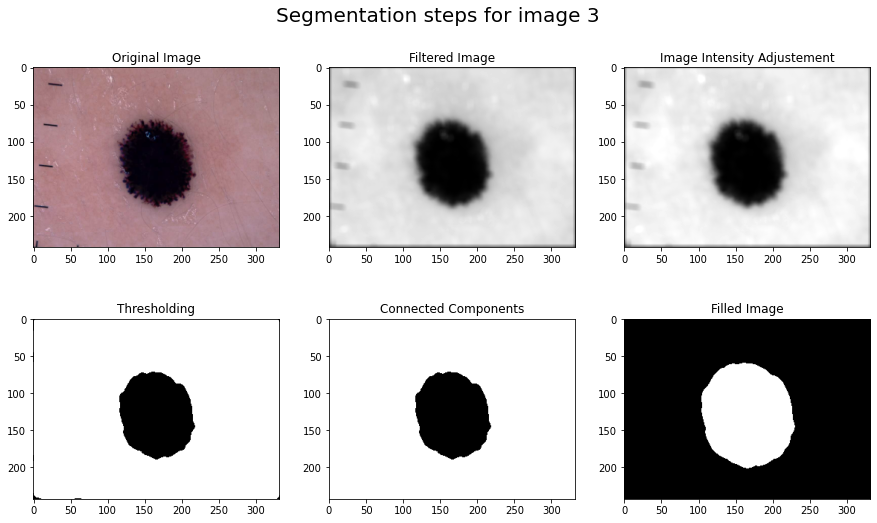

In [27]:
#@title
for c in range(3):
  steps = [lesions[c]]+segment(lesions[c][:,:,1])
  fig, axs = plt.subplots(2, 3,figsize=(15,8))
  fig.suptitle(f'Segmentation steps for image {c+1}',fontsize=20)
  k=0
  plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9 , top=0.9  , wspace=0.2, hspace=0.2)
  for i in range(2):
    for j in range(3):
      axs[i][j].imshow(steps[k],cmap='gray');
      axs[i][j].set_title(f'{steps_names[k]}')
      axs[i][j].grid(False)
      k+=1
  
  plt.show()

### Comments : Limits of results + Perspectives 
* Image 1 : in the third image :  the The Role of CCA operation in eliminating the uneccessary parts of the skin lesion image such as blue marks. However this algorithm fails in detecting the right edge of the lesion part by eliminating a consistent part of the lesion and considering it as part of the normal skin. Indeed the intensity gap between the main part of the lesion and the adjunct part led to a misleading Otsu's threshold (Pixels between these parts have low intensity thus they will be given 1 unlike the lesion part labeled by 0) and thus to a seperation(Break) between both parts and finally elimination in the connected component analysis operation.   
To improve it, it is necessary to consider an operation that performs the intensity adjustment in a fair and intelligent way on the whole lesion area.   
* Image 2 : Looks perfectly segmented. The mask obrtained is perfectly in accordance with the expected result. Yet, we can always notice the difference between the automated result and the maual ssegmentation. This is due to the fact that the manual segmentatin process is done consecutively by different dermatologists with differnent points of view and backgrounds. So we conclude that the autotmated mask remains only an approximation to what dermatologists would expect. For amelioration this algorithm need to be trained on larger dataset to best the best finetuning of hyperparameters needed on the sementaiton process.  
* Image 3 : Dilation role : idea of choosing the best radius for each image is discussed furthur. 


### Limits of the process noticed in the thresholding step

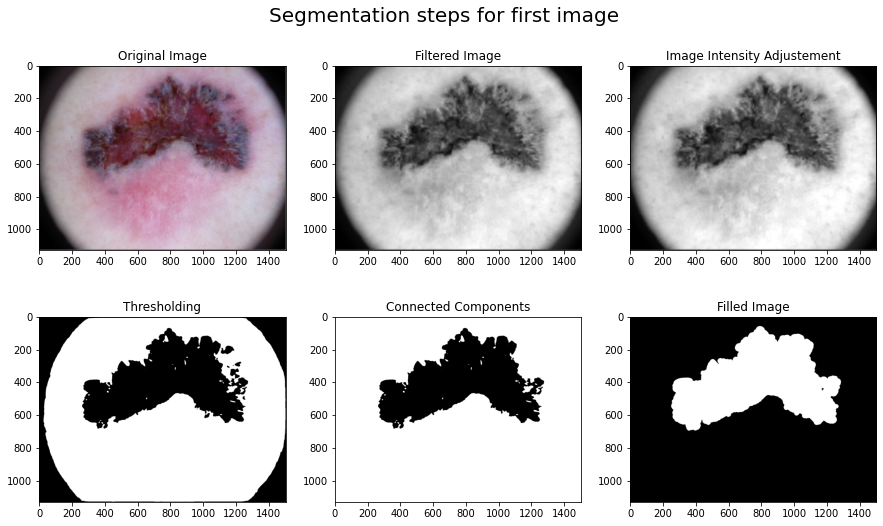

In [29]:
#@title
image_1 = plt.imread(lesion_path+train[0])
steps = [image_1]+segment(image_1[:,:,2])
fig, axs = plt.subplots(2, 3,figsize=(15,8))
fig.suptitle(f'Segmentation steps for first image',fontsize=20)
k=0
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9 , top=0.9  , wspace=0.2, hspace=0.2)
for i in range(2):
  for j in range(3):
    axs[i][j].imshow(steps[k],cmap='gray');
    axs[i][j].set_title(f'{steps_names[k]}')
    axs[i][j].grid(False)
    k+=1
  
plt.show()

* This image is not  well segmented. In fact, this segmentation method is based on the intensity of the colors, so the pixels that are part of the lesion and which values are lower than the threshold determined by the segmentation method are considered as pixels of normal skin.

* We notice that after the filtering operation, the intensity of the area which  is pink in the original image becomes low  and that even after the intensity adjustment its contrast remains weak, so the segmentation method consider it as a normal skin region.

* We can for example propose as a perspective another algorithm that takes into consideration the regions belonging to the lesion whatever its color intensity.

#  Segmentation Results obtained with 10 Skin lesion images:

- This dataset includes sevaral caracterasitics : Images with 
   * Black Border - Some Haired images - Images with many artifacts ( imperfections ) - Images with uncessary components ( blue Marks ). 
   

In [ ]:
channel = 1 # Green
path = os.getcwd()
result_path = path + '/melanoma/Channel_Green/'
results = sorted(os.listdir(result_path))
results.append(results.pop(0))

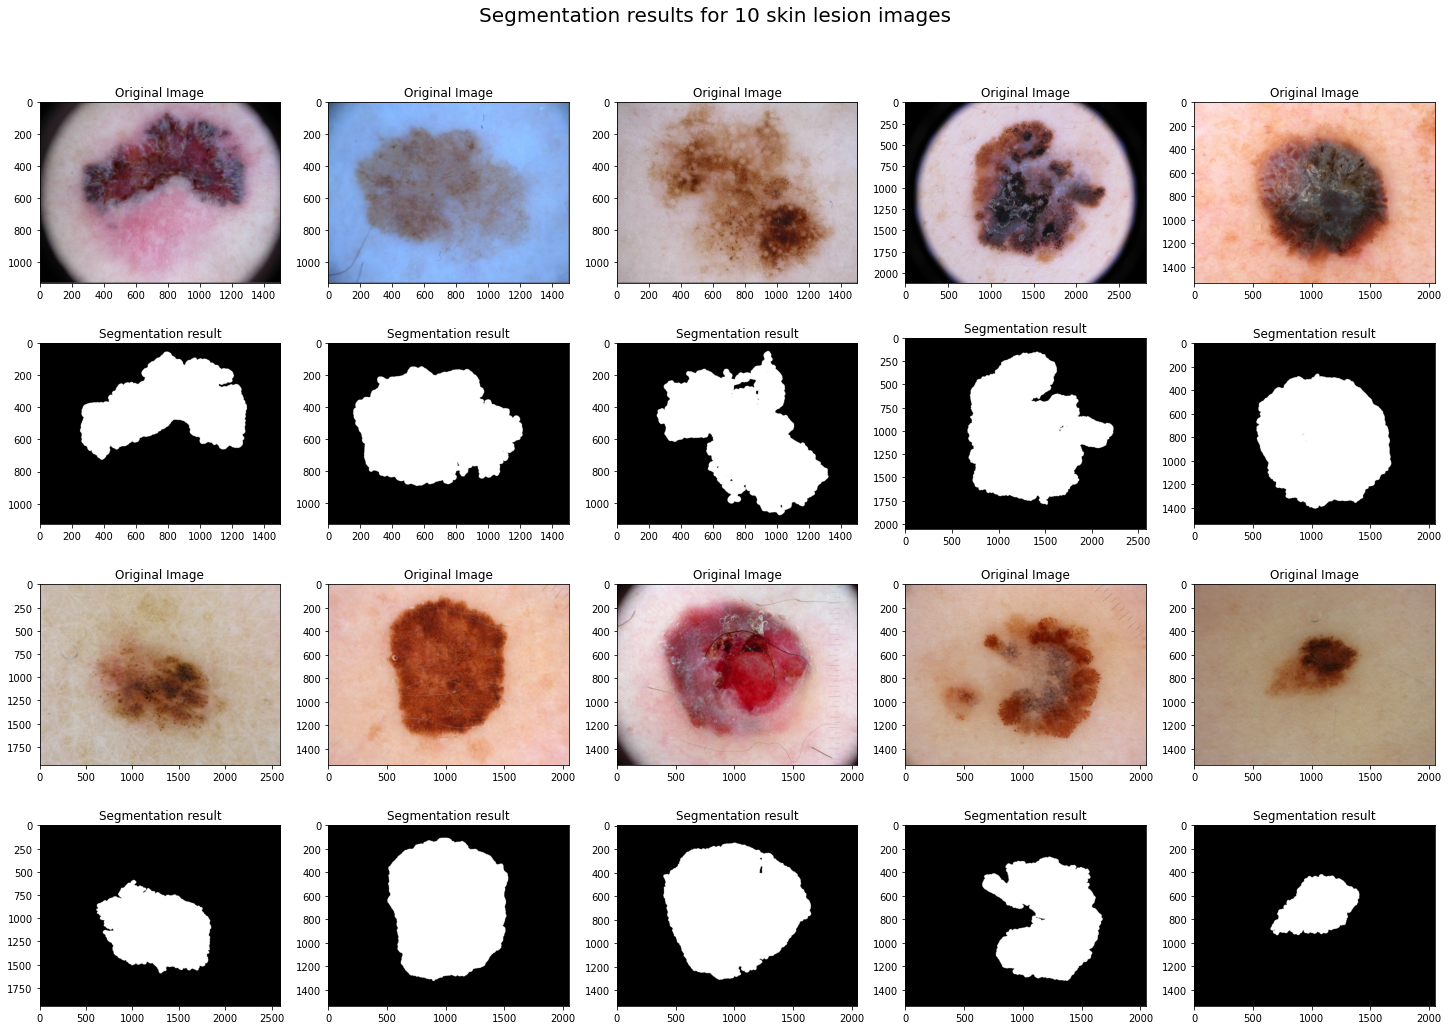

In [ ]:
#@title
fig, axs = plt.subplots(4, 5,figsize=(25,17))
plt.suptitle('Segmentation results for 10 skin lesion images',fontsize=20,y=0.95)
for i in range(5):
    original_image = plt.imread(lesion_path+train[i])
    result = plt.imread(result_path+results[i])
    axs[0][i].imshow(original_image);
    axs[0][i].set_title('Original Image');
    axs[1][i].imshow(result,cmap='gray');
    axs[1][i].set_title('Segmentation result');
    original_image = plt.imread(lesion_path+train[i+5])
    result = plt.imread(result_path+results[i+5])
    axs[2][i].imshow(original_image);
    axs[2][i].set_title('Original Image');
    axs[3][i].imshow(result,cmap='gray');
    axs[3][i].set_title('Segmentation result');

#IV. Dilation : Choice of best radius:
LOOP on radius ( work to be done )  

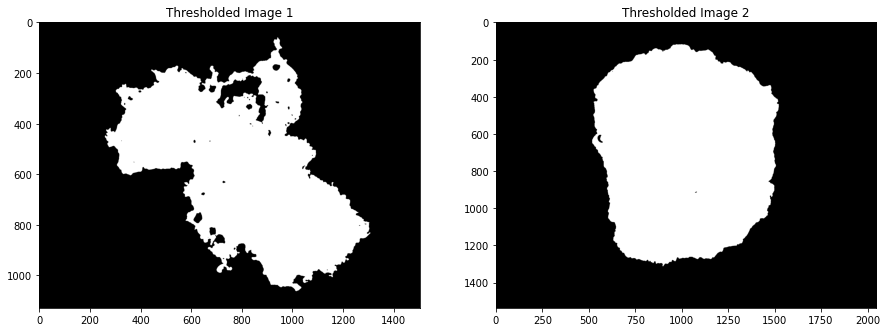

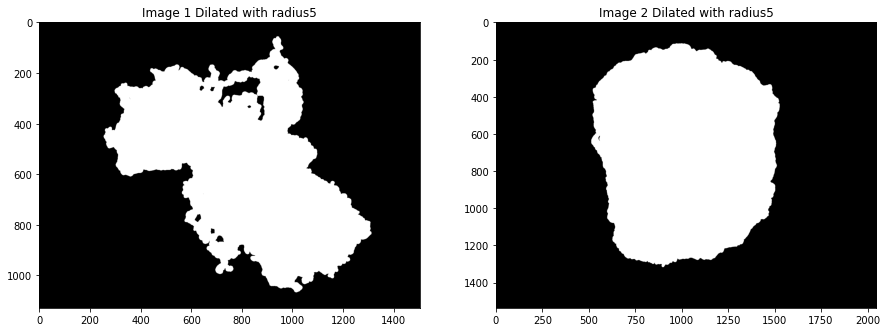

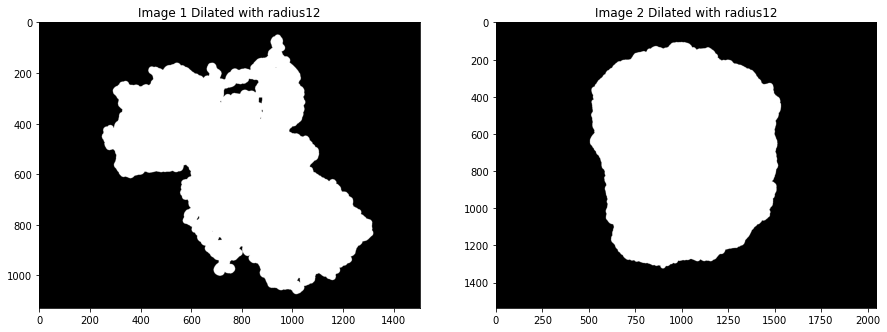

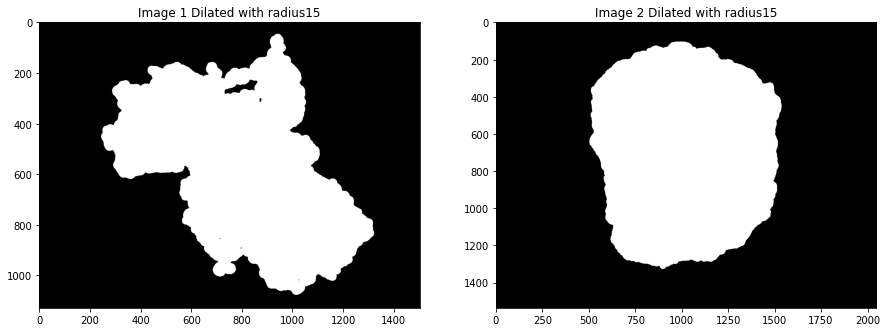

In [ ]:
#@title
from dilation import fill_holes
radius_list = [5,12,15] 
M1,M2 = plt.imread(lesion_path+train[2]),plt.imread(lesion_path+train[6])
seg1,seg2 = segment(M1[:,:,1]),segment(M2[:,:,1])
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax[0].imshow(1-seg1[-2],cmap='gray')
ax[0].set_title('Thresholded Image 1');
ax[1].imshow(1-seg2[-2],cmap='gray')
ax[1].set_title('Thresholded Image 2');
for r in radius_list :
  dilated1,dilated2 = fill_holes(1-seg1[-2],r),fill_holes(1-seg2[-2],r)
  fig, ax = plt.subplots(1,2,figsize=(15,10))
  ax[0].imshow(dilated1,cmap='gray')
  ax[0].set_title(f'Image 1 Dilated with radius{r}');
  ax[1].imshow(dilated2,cmap='gray')
  ax[1].set_title(f'Image 2 Dilated with radius{r}');


* After applying three dilations on two segmented images by changing the radius from 5 to 12 and then to 15 , we notice that for the first image even at the last iteration there are still holes that are not filled and the size of the second image  increase too much.
So this method of segmentation causes the underestimation of some images and the overestimation of others, hence the problem encountered in the dilation step.
 

## V . General Visualization of results
* Operating 15 color channels transformation inluding those obtained after segmentation
* Calculating segmentation results for all generated data  = 10 * 15 = 150 

In [ ]:
#@title

def or_function(channels, n,m ):
    """"This function operates the or operation between two segmented images """"
    rond =np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            pix = 0
            for c in channels:
                pix = pix or c[i,j]
            rond[i,j]=pix
    return rond

def segmentation_per_channel(im,indice,im1):
    """ This function genertes 15 segmentaion results(of channeled image)  per image """
    image=im.copy()
    image=image.astype(np.int)
    # border removal 
    if indice in (0,3,7):
        l1,l2= border.test(image,0)
        c1,c2 = border.test(image,1)
        removed_border = image[l1:l2,c1:c2]
        im1_removed = im1[l1:l2,c1:c2]
        
    else:
        removed_border=image.copy()
        im1_removed = im1.copy()
    # # color channel extraction 
    channels = color_channel(removed_border)
    
    # Segmentation per channel ##
    seg = {}
    for c,channeled in channels.items():
        result = segment(channeled)
        seg[c]=result[-1]
    R,G,B,RGB,X,Y,Z= seg['R'],seg['G'],seg['B'],seg['RGB'],seg['X'],seg['Y'],seg['Z']
    n,m=R.shape
    XOYOZ,XOYOZOR,XOYOR = or_function((X,Y,Z),n,m),or_function((X,Y,Z,R),n,m),or_function((X,Y,R),n,m)
    ROGOB ,RGBOR= or_function((R,G,B),n,m),or_function((RGB,R),n,m)
    seg['XOYOZ'],seg['XOYOZOR'],seg['XOYOR'],seg['ROGOB'],seg['RGBOR']=XOYOZ,XOYOZOR,XOYOR,ROGOB,RGBOR
    return seg,im1_removed

In [ ]:
# data : dictionnary containing all segmented channeled images of 10 original images, 
# The nmber of these images are chosen as key for the dictionary.

data={} 

# 15 channels - 10 images 
sensitivity,specificity,accuracy,similarity=np.zeros((15,10)),np.zeros((15,10)),np.zeros((15,10)),np.zeros((15,10))
Jaccard = np.zeros((15,10))
for i in range(len(train)):
    original_image = plt.imread(path+'/melanoma/skinlesion_image/'+train[i])
    manual = plt.imread(path+'/melanoma/ground_truth/'+ground_truth[i])
    data[i+1],im1_removed=segmentation_per_channel(original_image,i,manual)  
    c=0 # limit 15
    for segmented in data[i+1].values():
        sensitivity[c,i],specificity[c,i],accuracy[c,i],similarity[c,i] = statistics(segmented,im1_removed)
        Jaccard[c,i] = Jaccard_Index(segmented,im1_removed)
        c+=1
    print('ok')

In [ ]:
#cd melanoma/
for i in range(1,11): # Saving Channel B segmentation results for all images.
  plt.imsave(f'image{i}_segmentation.png',data[i]['G'],cmap='gray')
for c,channeled in data[2].items():
  plt.imsave(f'{c}_segmentation.png',channeled,cmap='gray')

In [ ]:
columns = ['sensitivity','specificity','accuracy','Dice','Jaccard_Index']
mean_performances = pd.DataFrame(columns=columns)
std_performances = pd.DataFrame(columns=columns)

# Calculating the mean per channel = 15 average measures of sensitivity,specificity,accuracy and similarity
for i in range(15): 
    mean_erros = [sensitivity[i,:].mean(),specificity[i,:].mean(),accuracy[i,:].mean(),accuracy[i,:].mean(),Jaccard[i,:].mean()]
    std_erros = [sensitivity[i,:].std(),specificity[i,:].std(),accuracy[i,:].std(),accuracy[i,:].std(),Jaccard[i,:].std()]
    mean_performances=mean_performances.append(pd.Series(mean_erros,index=columns),ignore_index=True)
    std_performances=std_performances.append(pd.Series(std_erros,index=columns),ignore_index=True)
     
channel_name = pd.Series(['R','G','B','RGB','I','L','YCbCr','X','Y','Z','XOYOZ','XOYOZOR','XOYOR','ROGOB','RGBOR'])
mean_performances = mean_performances.set_index(channel_name)
std_performances = std_performances.set_index(channel_name)
mean_performances['channel'] = channel_name
mean_performances.to_csv('Mean_of_Performances.csv')
std_performances.to_csv('Std_of_Performances.csv')

### This table entitled 'mean_performances' represents mean values of the four considred metrics : sensitivity, specificity, accuracy, Dice, Jaccard_Index. These mean values are obtained after calculating performances for each color channel segmentation.

In [ ]:
channel_name = pd.Series(['R','G','B','RGB','I','L','YCbCr','X','Y','Z','XOYOZ','XOYOZOR','XOYOR','ROGOB','RGBOR'])
mean_performances  =pd.read_csv(path + '/Mean_of_Performances.csv')
mean_performances = mean_performances.set_index(channel_name)
mean_performances.pop('Unnamed: 0')
mean_performances

sensitivity  specificity  accuracy      Dice  Jaccard_Index
R           0.632607     0.970209  0.838023  0.838023       0.610985
G           0.752519     0.997930  0.896293  0.896293       0.748365
B           0.754153     0.995873  0.895118  0.895118       0.745500
RGB         0.735820     0.998156  0.890074  0.890074       0.732100
I           0.746983     0.997812  0.894134  0.894134       0.742557
L           0.984159     0.086952  0.414665  0.414665       0.383990
YCbCr       0.735820     0.998156  0.890074  0.890074       0.732100
X           0.732069     0.998177  0.889572  0.889572       0.728407
Y           0.742255     0.998103  0.893083  0.893083       0.738441
Z           0.783399     0.996137  0.905032  0.905032       0.775363
XOYOZ       0.790306     0.996065  0.907954  0.907954       0.782142
XOYOZOR     0.791443     0.967150  0.890399  0.890399       0.753194
XOYOR       0.744507     0.969102  0.875908  0.875908       0.712651
ROGOB       0.794473     0.966817  0.891258  0.891258       0.755359
RGBOR       0.739107     0.969185  0.873751  0.873751       0.707628

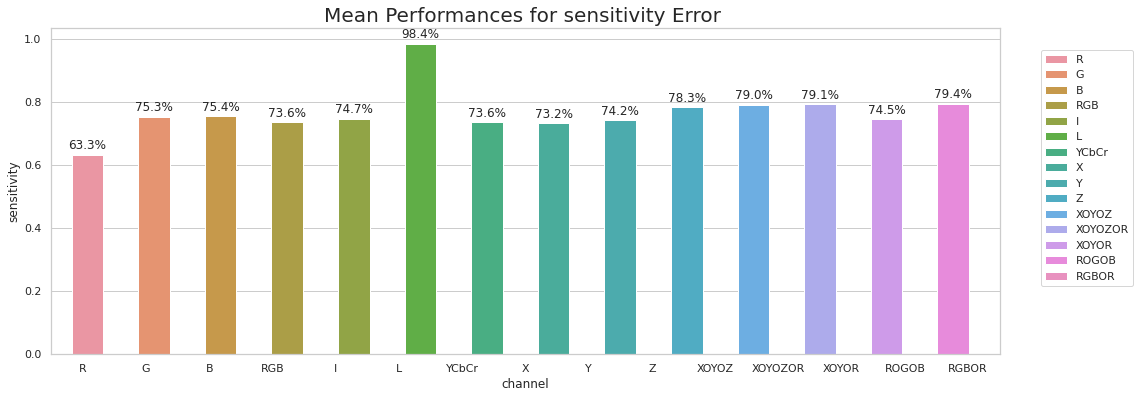

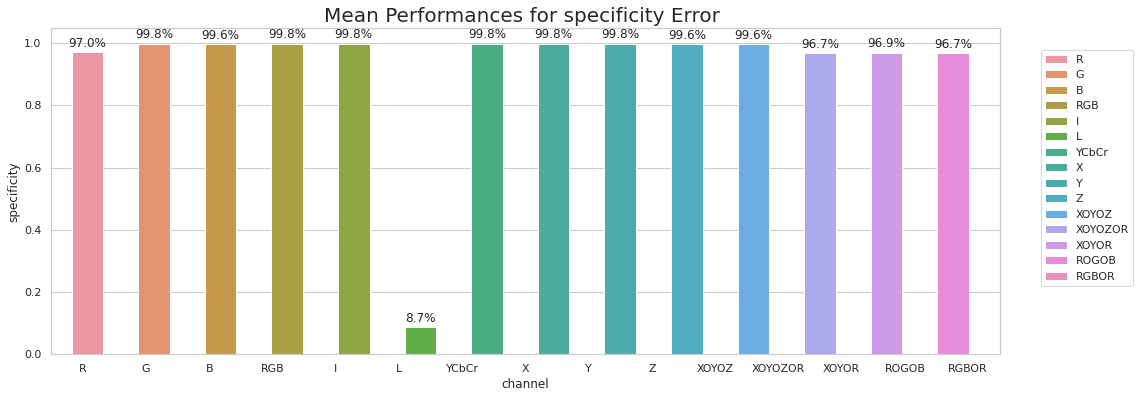

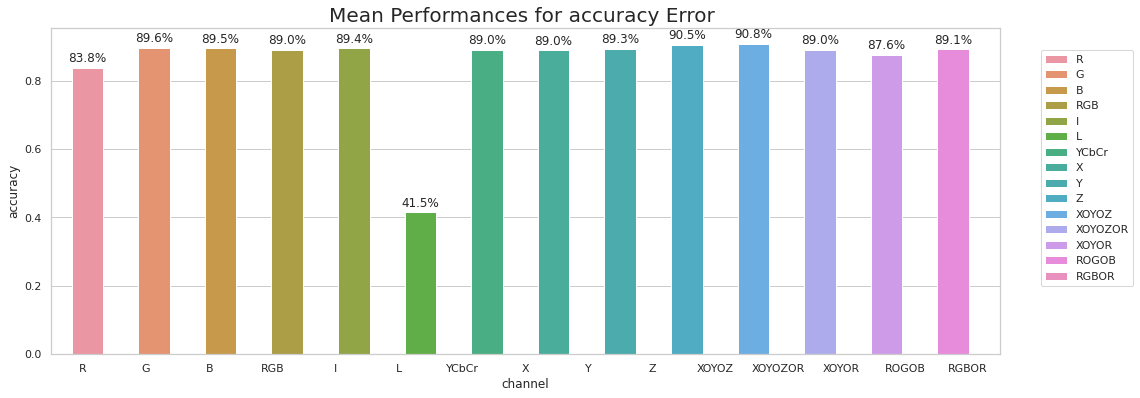

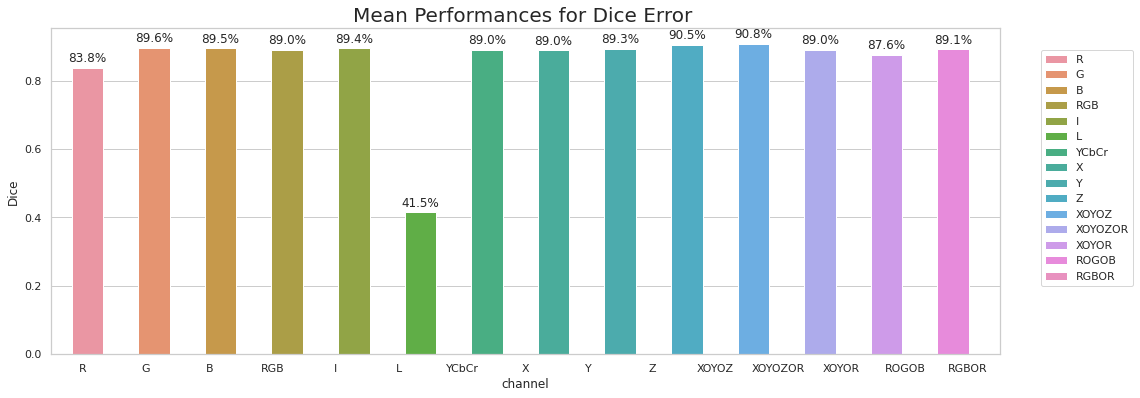

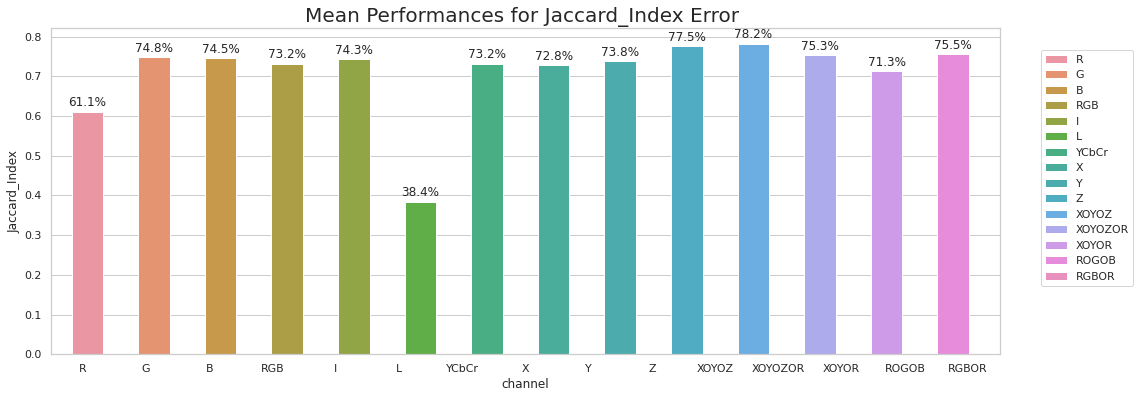

In [ ]:
import seaborn as sns
for i in range(5):
  fig, ax = plt.subplots(1,1, figsize=(17, 6))
  
  df = mean_performances
  sns.set_theme(style="whitegrid")
  splot = sns.barplot(x='channel',y=columns[i],data=df,hue='channel')
  for p in splot.patches:
      diff = 0.5-p.get_width()  
      p.set_width(0.5),p.set_x(p.get_x() + diff * .5)
      splot.annotate('{:.1f}%'.format(p.get_height()*100), 
                   (p.get_x() + p.get_width() / 2., p.get_height()),    
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
  plt.title(f'Mean Performances for {columns[i]} Error ',fontsize=20)
  plt.legend(bbox_to_anchor=(1.02, 1),
           borderaxespad=2)
  plt.show()

In [ ]:
channel_name = pd.Series(['R','G','B','RGB','I','L','YCbCr','X','Y','Z','XOYOZ','XOYOZOR','XOYOR','ROGOB','RGBOR'])
std_performances  =pd.read_csv(path + '/melanoma/Std_of_Performances.csv')
std_performances = std_performances.set_index(channel_name)
std_performances.pop('Unnamed: 0')
std_performances

sensitivity  specificity  accuracy      Dice  Jaccard_Index
R           0.182084     0.086930  0.128040  0.128040       0.190685
G           0.163991     0.003565  0.098419  0.098419       0.159209
B           0.206714     0.005828  0.099629  0.099629       0.198696
RGB         0.167035     0.003327  0.103007  0.103007       0.162479
I           0.163398     0.003862  0.097894  0.097894       0.158124
L           0.047523     0.154059  0.162614  0.162614       0.141643
YCbCr       0.167035     0.003327  0.103007  0.103007       0.162479
X           0.163200     0.003269  0.099978  0.099978       0.158548
Y           0.163439     0.003358  0.098955  0.098955       0.158820
Z           0.169298     0.005492  0.094349  0.094349       0.161816
XOYOZ       0.165220     0.005504  0.092181  0.092181       0.157683
XOYOZOR     0.164844     0.087149  0.094783  0.094783       0.154438
XOYOR       0.163077     0.087220  0.103274  0.103274       0.158602
ROGOB       0.165259     0.087170  0.093830  0.093830       0.154150
RGBOR       0.164310     0.087191  0.105065  0.105065       0.160081

## Interpretations # 
* Before the evaluation of this segmentation process we noticed that the two channels "H" and "S" extracted from the HSI color space give disastrous results where images are completely distorted. This may be the result of the complexity of the transformation applied to RGB channels which is unlike other linear transformations. We decided to remove these channels which we considered as outliers in our work because the mean and Std erros won't be faithful when including these channels.
* We notice that  the color channel "L" of Lab space has the best performance with the "Sensitivity Metric " however it has the lowest performance with the other metrics. We can conclude that we can't consider this metric as a good benchmark as it gives poor results for the rest of channels unlike other metrics.

* According to the previous plots, we obtain similar results to those in artice. Indeed, the two channels obtained by the Or operation " XoYoZ " and " XoYoZoR" are give the best performance for 3 metrics " Accuracy " , " Dice " and " Jaccard ".
This remark is confirmed when analysing the STD of performances. We can see that these channels have almost the minimum values among for most of metrics and this leads to the conclusion that the segmentation erros are less likely to occur with these channels. This has convinced us with the choice of channels the authors made when studying this method.
* In RGB color Space, "Green" channel outperforms the rest of other channels. Indeed when comparing the channeled images of our Data, we have noticed that green channel images have the strongest contrast where more details are displayed. This helped us further in the segmentation step because our work is based on the variation of intensity in the image where high intensity pixels are lesion. 

